In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
from self_supervised.layers import *
import sklearn
from scipy.io import loadmat

In [3]:
from utils.custom_vit import *
from utils.attention import *
from utils.object_crops import *
from utils.part_crops import *
from utils.multi_crop_model import *

from fastai.callback.wandb import WandbCallback
import wandb

In [4]:
datapath = Path("../data/cub_200_2011/CUB_200_2011/")

In [5]:
datapath.ls().map(lambda o: o.name)

(#9) ['classes.txt','bounding_boxes.txt','images.txt','README','images','attributes','parts','train_test_split.txt','image_class_labels.txt']

In [6]:
filenames = get_image_files(datapath/'images')

In [7]:
len(filenames)

11788

In [8]:
filenames[:3]

(#3) [Path('../data/cub_200_2011/CUB_200_2011/images/127.Savannah_Sparrow/Savannah_Sparrow_0059_119810.jpg'),Path('../data/cub_200_2011/CUB_200_2011/images/127.Savannah_Sparrow/Savannah_Sparrow_0067_118491.jpg'),Path('../data/cub_200_2011/CUB_200_2011/images/127.Savannah_Sparrow/Savannah_Sparrow_0118_118603.jpg')]

In [9]:
train_test_split_df = pd.read_csv(datapath/'train_test_split.txt', delimiter=' ', names=['image_id', 'is_train'])

In [10]:
train_test_split_df.head()

,image_id,is_train
0,1,0
1,2,1
2,3,0
3,4,1
4,5,1


In [11]:
train_test_split_df['is_train'].value_counts()

1    5994
0    5794
Name: is_train, dtype: int64

In [12]:
images_df = pd.read_csv(datapath/'images.txt', delimiter=' ', names=['image_id', 'filename'])

In [13]:
images_df.head()

,image_id,filename
0,1,001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg
1,2,001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg
2,3,001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg
3,4,001.Black_footed_Albatross/Black_Footed_Albatross_0074_59.jpg
4,5,001.Black_footed_Albatross/Black_Footed_Albatross_0014_89.jpg


In [14]:
merged_df = images_df.merge(train_test_split_df, on='image_id')

In [15]:
fn2istrain = dict(zip(merged_df['filename'], merged_df['is_train']))

### Dataset

In [16]:
filenames[0]

Path('../data/cub_200_2011/CUB_200_2011/images/127.Savannah_Sparrow/Savannah_Sparrow_0059_119810.jpg')

In [17]:
train_filenames = [datapath/'images'/o for o in merged_df.query("is_train == 1")['filename'].values]

In [18]:
len(filenames)

11788

In [19]:
def read_image(filename):      return PILImage.create(filename)
def read_image_size(filename): return PILImage.create(filename).shape

In [20]:
def read_label(filename): return filename.parent.name

In [21]:
# sizes = parallel(read_image_size, filenames)

In [22]:
size,bs = 448,4

tfms = [[read_image, ToTensor, RandomResizedCrop(size, min_scale=1.)], 
        [read_label, Categorize()]]

valid_splitter = lambda o: True if not fn2istrain[str(Path(o.parent.name)/o.name)] else False 
dsets = Datasets(filenames, tfms=tfms, splits=FuncSplitter(valid_splitter)(filenames))
# dsets = Datasets(train_filenames, tfms=tfms, splits=None)


batch_augs = aug_transforms()

stats = imagenet_stats

batch_tfms = [IntToFloatTensor] + batch_augs + [Normalize.from_stats(*stats)]
dls = dsets.dataloaders(bs=bs, after_batch=batch_tfms)

In [23]:
len(dls.train_ds), len(dls.valid_ds)

(5994, 5794)

### Model

In [24]:
def interpolate_bil(x,sz): return F.interpolate(x,mode='bilinear',align_corners=True, size=(sz,sz))

def apply_attn_erasing(x, attn_maps, thresh, p=0.5): 
    "x: bs x c x h x w, attn_maps: bs x h x w"
    erasing_mask = (attn_maps>thresh).unsqueeze(1)
    ps = torch.zeros(erasing_mask.size(0)).float().bernoulli(p).to(erasing_mask.device)
    rand_erasing_mask = 1-erasing_mask*ps[...,None,None,None]
    return rand_erasing_mask*x

class ViTEncoder(Module):
    "Timm ViT encoder which return encoder outputs and optionally returns attention weights with gradient checkpointing"
    def __init__(self, vit, nblocks=12, checkpoint_nchunks=2, return_attn_wgts=True):
                
        # initialize params
        self.patch_embed = vit.patch_embed
        self.cls_token = vit.cls_token
        self.pos_embed = vit.pos_embed
        self.pos_drop = vit.pos_drop
        
        # until any desired layers
        self.blocks = vit.blocks[:nblocks]        
        
        # gradient checkpointing
        self.checkpoint_nchunks = checkpoint_nchunks
        
        # return attention weights from L layers
        self.return_attn_wgts = return_attn_wgts
         
    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.pos_drop(x + self.pos_embed)

        # collect attn_wgts from all layers
        if self.return_attn_wgts:
            attn_wgts = []
            for i,blk in enumerate(self.blocks):
                if i<self.checkpoint_nchunks: x,attn_wgt = checkpoint(blk, x)
                else:                         x,attn_wgt = blk(x)
                attn_wgts.append(attn_wgt)
            return x,attn_wgts
        
        else:
            for i,blk in enumerate(self.blocks):
                if i<self.checkpoint_nchunks: x,_ = checkpoint(blk, x)
                else:                         x,_ = blk(x)
            return x
        
    def forward(self, x):
        return self.forward_features(x)
    
    
class MultiCropViT(Module):
    "Multi Scale Multi Crop ViT Model"
    def __init__(self, 
                 encoder, 
                 num_classes,
                 input_res=384, high_res=786, min_obj_area=112*112, crop_sz=224,
                 crop_object=True, crop_object_parts=True,
                 do_attn_erasing=True, p_attn_erasing=0.5, attn_erasing_thresh=0.7,
                 encoder_nblocks=12, checkpoint_nchunks=12):
        
        store_attr()

        self.image_encoder = ViTEncoder(encoder, nblocks=encoder_nblocks, checkpoint_nchunks=checkpoint_nchunks)
        self.norm = partial(nn.LayerNorm, eps=1e-6)(768)        
        self.classifier = create_cls_module(768, num_classes, lin_ftrs=[768], use_bn=False, first_bn=False, ps=0.)
    
        
    def forward(self, xb_high_res):

        # get full image attention weigths / feature
        self.image_encoder.return_attn_wgts = True
        xb_input_res = F.interpolate(xb_high_res, size=(self.input_res,self.input_res))
        _, attn_wgts = self.image_encoder(xb_input_res)
        self.image_encoder.return_attn_wgts = False
        
        # get attention maps
        attn_maps = generate_batch_attention_maps(attn_wgts, None, mode=None).detach()
        attn_maps_high_res = interpolate_bil(attn_maps[None,...],self.high_res)[0]
        attn_maps_input_res = interpolate_bil(attn_maps[None,...],self.input_res)[0]
        

        
        #### ORIGINAL IMAGE ####
        # original image attention erasing and features
        if (self.training and self.do_attn_erasing):
            xb_input_res = apply_attn_erasing(xb_input_res, attn_maps_input_res, self.attn_erasing_thresh, self.p_attn_erasing)
        x_full = self.image_encoder(xb_input_res)

        
        
        #### OBJECT CROP ####        
        if self.crop_object:
            # get object bboxes
            batch_object_bboxes = np.vstack([generate_attention_coordinates(attn_map, 
                                                                            num_bboxes=1,
                                                                            min_area=self.min_obj_area,
                                                                            random_crop_sz=self.input_res)
                                                    for attn_map in to_np(attn_maps_high_res)])
            # crop objects
            xb_objects, attn_maps_objects = [], []
            for i, obj_bbox in enumerate(batch_object_bboxes):
                minr, minc, maxr, maxc = obj_bbox
                xb_objects        += [interpolate_bil(xb_high_res[i][:,minr:maxr,minc:maxc][None,...],self.input_res)[0]]
                attn_maps_objects += [interpolate_bil(attn_maps_high_res[i][minr:maxr,minc:maxc][None,None,...],self.input_res)[0][0]]
            xb_objects,attn_maps_objects = torch.stack(xb_objects),torch.stack(attn_maps_objects)

            # object image attention erasing and features
            if (self.training and self.do_attn_erasing):
                xb_objects = apply_attn_erasing(xb_objects, attn_maps_objects, self.attn_erasing_thresh, self.p_attn_erasing)
            x_object = self.image_encoder(xb_objects)
                    
        

        #### OBJECT CROP PARTS ####
        if self.crop_object_parts:
            #get object crop bboxes
            small_attn_maps_objects = interpolate_bil(attn_maps_objects[None,],self.input_res//3)[0] # to speed up calculation
            batch_crop_bboxes = generate_batch_crops(small_attn_maps_objects.cpu(),
                                                     source_sz=self.input_res//3, 
                                                     targ_sz=self.input_res, 
                                                     targ_bbox_sz=self.crop_sz,
                                                     num_bboxes=2,
                                                     nms_thresh=0.1)

            # crop object parts
            xb_crops1,xb_crops2 = [],[]
            for i, crop_bboxes in enumerate(batch_crop_bboxes):
                minr, minc, maxr, maxc = crop_bboxes[0]
                xb_crops1 += [interpolate_bil(xb_objects[i][:,minr:maxr,minc:maxc][None,...],self.input_res)[0]]
                minr, minc, maxr, maxc = crop_bboxes[1]
                xb_crops2 += [interpolate_bil(xb_objects[i][:,minr:maxr,minc:maxc][None,...],self.input_res)[0]]
            xb_crops1,xb_crops2 = torch.stack(xb_crops1),torch.stack(xb_crops2)

            # crop features
            x_crops1 = self.image_encoder(xb_crops1)
            x_crops2 = self.image_encoder(xb_crops2)
        
        
        # predict
        x_full = self.norm(x_full)[:,0]
        if self.crop_object:
            x_object = self.norm(x_object)[:,0]
            if self.crop_object_parts:
                x_crops1 = self.norm(x_crops1)[:,0]
                x_crops2 = self.norm(x_crops2)[:,0]
                return self.classifier(x_full), self.classifier(x_object), self.classifier(x_crops1), self.classifier(x_crops2)
            return self.classifier(x_full), self.classifier(x_object)
        return  self.classifier(x_full)

### Training

In [25]:
def model_splitter(m): return L(m.image_encoder, m.norm, m.classifier).map(params)

In [26]:
class LossFuncA(Module): # only object
    def __init__(self):               self.lf = LabelSmoothingCrossEntropyFlat(0.2)
    def forward(self, preds, targs):  return self.lf(preds[1],targs)
    
class LossFuncB(Module): # full + object
    def __init__(self):               self.lf = LabelSmoothingCrossEntropyFlat(0.2)
    def forward(self, preds, targs):  return self.lf(preds[0],targs) + self.lf(preds[1],targs)
    
class LossFuncC(Module): # full + object + crops
    def __init__(self):               self.lf = LabelSmoothingCrossEntropyFlat(0.2)
    def forward(self, preds, targs):  return self.lf(preds[0],targs) + self.lf(preds[1],targs) + (self.lf(preds[2],targs)+self.lf(preds[3],targs))/2

In [27]:
def accuracyA(preds, targs): return accuracy(preds[0], targs) # full
def accuracyB(preds, targs): return accuracy(preds[1], targs) # full, object
def accuracyC(preds, targs): return accuracy((preds[2]+preds[3])/2, targs) # full, object, crops

In [28]:
import gc

In [29]:
# exp 7 - full image + object + crops
model_config = dict(crop_object=True, crop_object_parts=True, do_attn_erasing=False, p_attn_erasing=0.5, attn_erasing_thresh=0.7)
loss_func = LossFuncC()
metrics =[accuracyA, accuracyB, accuracyC]


# modified timm vit encoder
arch = "vit_base_patch16_384"
_encoder = create_encoder(arch, pretrained=True, n_in=3)
encoder = VisionTransformer(img_size=384, patch_size=16, embed_dim=768, depth=12, num_heads=12)
encoder.head = Identity()
encoder.load_state_dict(_encoder.state_dict());


high_res=size
min_obj_area=64*64
crop_sz=128


mcvit_model = MultiCropViT(encoder, num_classes=dls.c, input_res=384, high_res=high_res, min_obj_area=min_obj_area, crop_sz=crop_sz,
                             encoder_nblocks=12, checkpoint_nchunks=12, **model_config)


cbs = []
learn = Learner(dls, mcvit_model, opt_func=ranger, cbs=cbs, metrics=metrics, loss_func=loss_func, splitter=model_splitter)
learn.to_fp16();

### Inference

In [88]:
learn.load("cup_model_epoch_1");

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [89]:
learn.model.eval().cuda();

In [107]:
xb_high_res, yb = dls.one_batch()

In [108]:
xb_high_res.shape

torch.Size([4, 3, 448, 448])

In [109]:
input_res = 384
high_res = 448
min_obj_area = 64*64

In [110]:
with torch.no_grad():
    # get full image attention weigths / feature
    learn.model.image_encoder.return_attn_wgts = True
    xb_input_res = F.interpolate(xb_high_res, size=(input_res,input_res))
    _, attn_wgts = learn.model.image_encoder(xb_input_res)
    learn.model.image_encoder.return_attn_wgts = False

In [111]:
# get attention maps
attn_maps = generate_batch_attention_maps(attn_wgts, None, mode=None).detach().cpu()
attn_maps_high_res = interpolate_bil(attn_maps[None,...],high_res)[0]
attn_maps_input_res = interpolate_bil(attn_maps[None,...],input_res)[0]

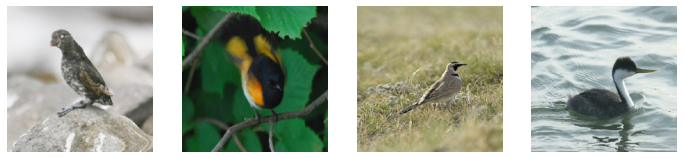

In [112]:
show_images(dls.after_batch.decode(xb_input_res))

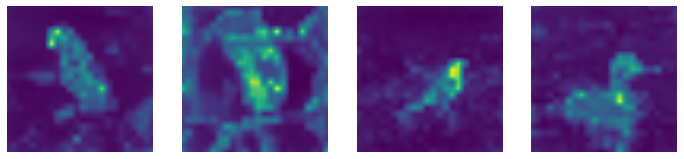

In [113]:
show_images(attn_maps_input_res)

In [114]:
# get object bboxes
batch_object_bboxes = np.vstack([generate_attention_coordinates(attn_map, 
                                                                num_bboxes=1,
                                                                min_area=min_obj_area,
                                                                random_crop_sz=input_res)
                                        for attn_map in to_np(attn_maps_high_res)])

In [115]:
# crop objects
xb_objects, attn_maps_objects = [], []
for i, obj_bbox in enumerate(batch_object_bboxes):
    minr, minc, maxr, maxc = obj_bbox
    xb_objects        += [interpolate_bil(xb_high_res[i][:,minr:maxr,minc:maxc][None,...],input_res)[0]]
    attn_maps_objects += [interpolate_bil(attn_maps_high_res[i][minr:maxr,minc:maxc][None,None,...],input_res)[0][0]]
xb_objects,attn_maps_objects = torch.stack(xb_objects),torch.stack(attn_maps_objects)

In [116]:
xb_objects_decoded = dls.after_batch.decode(xb_objects.cpu())

In [117]:
xb_high_res_decoded = dls.after_batch.decode(xb_high_res.cpu())

In [118]:
xb_high_res_decoded.shape

torch.Size([4, 3, 448, 448])

In [119]:
attn_maps_high_res.shape

torch.Size([4, 448, 448])

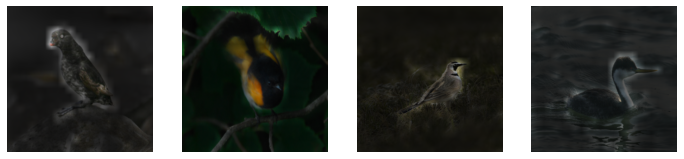

In [120]:
show_images((xb_high_res_decoded/255)*attn_maps_high_res.unsqueeze(1))

In [121]:
attn_on_images = (xb_high_res_decoded/255)*attn_maps_high_res.unsqueeze(1)

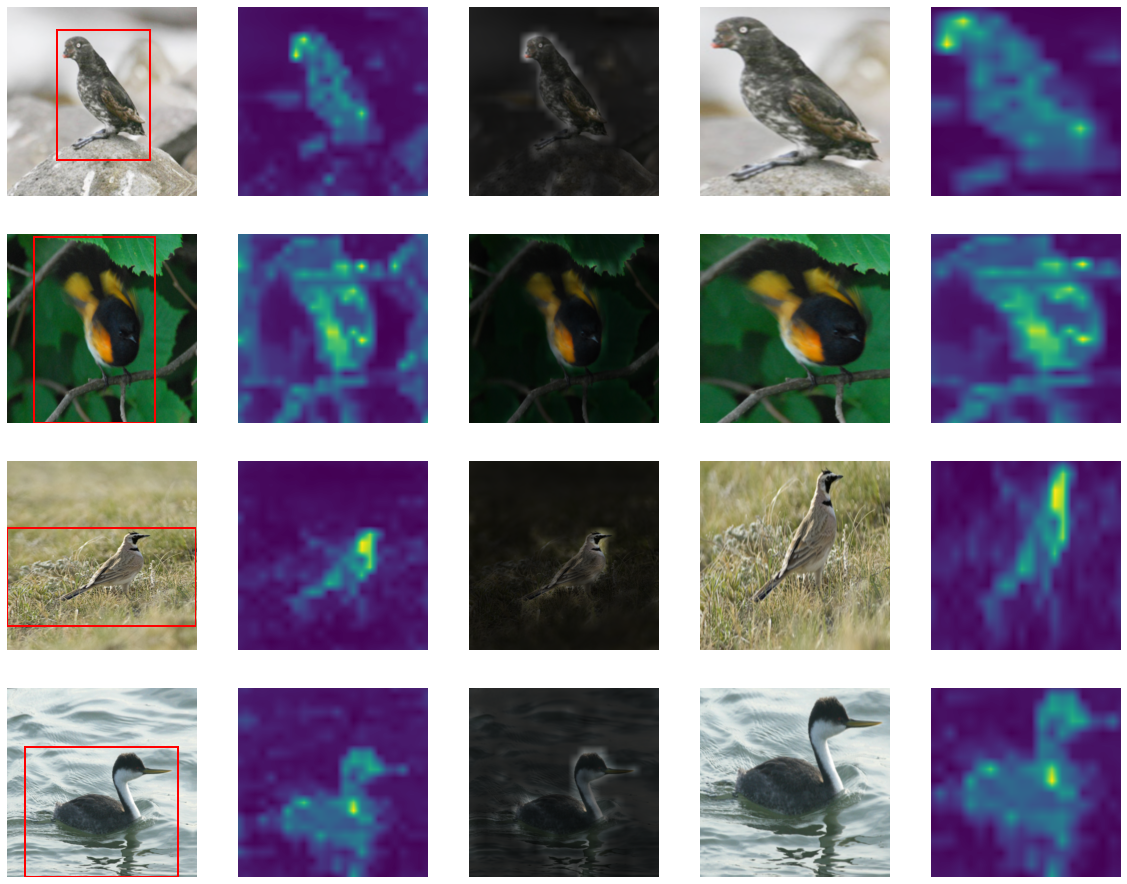

In [122]:
fig, axes = plt.subplots(4,5, figsize=(5*4,4*4))

for ax, img, full_attn_map,attn_on_img,obj_bbox, obj, attn_map in zip(axes, 
                                                         xb_high_res_decoded, 
                                                         attn_maps_high_res,
                                                         attn_on_images,
                                                         batch_object_bboxes,
                                                         xb_objects_decoded, attn_maps_objects):

    
    show_image(img, ax=ax[0])
    minr, minc, maxr, maxc = obj_bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
    ax[0].add_patch(rect)
    
    show_image(full_attn_map, ax=ax[1])
    
    show_image(attn_on_img, ax=ax[2])
    
    show_image(obj, ax=ax[3])
    show_image(attn_map, ax=ax[4])

In [123]:
fig.savefig("birds_bboxes_5.png")

### fin